## Variational Autoencoders (VAE) Study notes
- https://pyro.ai/examples/vae.html
- Background
  - the VAE is a particular setup for doing variational inference for a certain class of models. The class of models is quite broad: basically any (unsupervised) density estimator with latent random variables.
  - We have N observed datapoints {xi}. Each datapoint is generated by a (local) latent random variable zi. There is also a parameter θ, which is global in the sense that all the datapoints depend on it. Note that since θ is a parameter, it’s not something we’re being Bayesian about. Finally, what’s of particular importance here is that we allow for each xi to depend on zi in a complex, non-linear way. In practice this dependency will be parameterized by a (deep) neural network with parameters θ. It’s this non-linearity that makes inference for this class of models particularly challenging.
- Variation of the non-linearity model
  - the neural network in pθ(x|z) can be varied in all the usual ways (number of layers, type of non-linearities, number of hidden units, etc.)
  - we can choose observation likelihoods that suit the dataset at hand: gaussian, bernoulli, categorical, etc and we can choose the number of dimensions in the latent space
- Local Random Variable
  - p(x,z)=sum(pθ(xi|zi)p(zi), i=1...N)
  - We call zi a local random variable. For any particular i, only the single datapoint xi depends on zi. As such the {zi} describe local structure, i.e. structure that is private to each data point. This factorized structure also means that we can do subsampling during the course of learning.

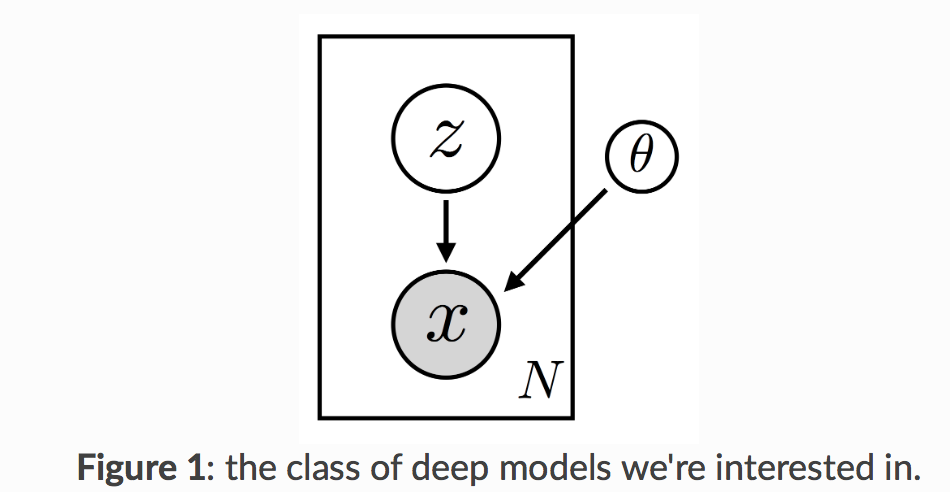

In [0]:
from IPython.display import Image
Image("Figure1.png", width=400)

- Good guess values for latent random variables
  - Recall that the job of the guide is to ‘guess’ good values for the latent random variables—good in the sense that they’re true to the model prior and true to the data. We would introduce variational parameters {λi} for each datapoint xi. These variational parameters would represent our belief about ‘good’ values of zi; for example, they could encode the mean and variance of a gaussian distribution in zi space. 
  - Amortization means that, rather than introducing variational parameters {λi}, we instead learn a function that maps each xi to an appropriate λi. Since we need this function to be flexible, we parameterize it as a neural network. We thus end up with a parameterized family of distributions over the latent z space that can be instantiated for all N datapoint xi.

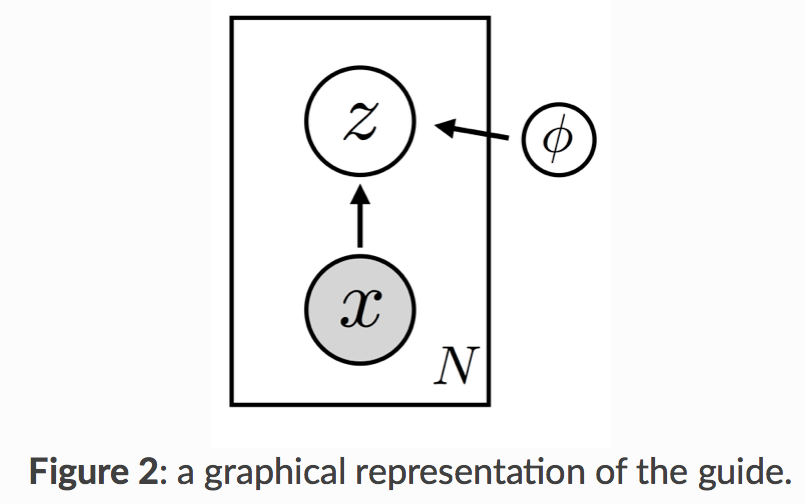

In [0]:
Image("Figure2.png", width=350)

- To find good values for parameters θ and ϕ: 
  - the log evidence logpθ(x) is large. this means our model is a good fit to the data.
  - the guide qϕ(z|x) provides a good approximation to the posterior.

### Working flow 
- Each X is being represented by a latent code z and that code gets mapped to images using the likelihood, which depends on the θ we’ve learned. This is why the likelihood is often called the decoder in this context: its job is to decode z into x . Note that since this is a probabilistic model, there is uncertainty about the z that encodes a given datapoint x .
- Once we’ve learned good values for θ and ϕ we can also go through the following exercise.
we start with a given X using our guide we encode it as z using the model likelihood we decode z and get a reconstructed image Xreco If we’ve learned good values for θ and ϕ , X and Xreco should be similar. This should clarify how the word autoencoder ended up being used to describe this setup: the model is the decoder and the guide is the encoder. Together, they can be thought of as an autoencoder.

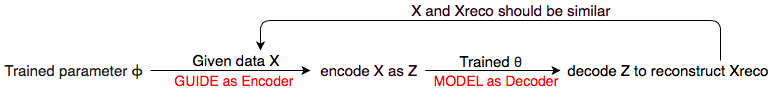

In [0]:
Image("working flow.png", width=800)

In [0]:
!pip install pyro-ppl

     |████████████████████████████████| 266kB 4.8MB/s 
     |████████████████████████████████| 61kB 21.1MB/s 
     |████████████████████████████████| 51kB 17.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/d4/de/b5/88300d2adc973a7ec963b339d2935d34a0cf02c08b613a8a5e
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built pyro-ppl opt-einsum
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
# MNIST - a collection of images of handwritten digits to test VAE
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [0]:
assert pyro.__version__.startswith('0.3.4')

# http://docs.pyro.ai/en/0.2.1-release/primitives.html
# Enable or disable validation checks in Pyro. 
# Validation checks provide useful warnings and errors, 
# e.g. NaN checks, validating distribution arguments and support values, etc. 
# which is useful for debugging. Since some of these checks may be expensive, 
# we recommend turning this off for mature models.
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

# https://www.guru99.com/smoke-testing.html
# Smoke testing: qualify the build for further formal testing. 
# The main aim of smoke testing is to detect early major issues. 
# Smoke tests are designed to demonstrate system stability and conformance to requirements.

# A build includes all data files, libraries, reusable modules, 
# engineered components that are required to implement one or more product functions.
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

### Example - loading MNIST dataset

In [0]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    # use transforms.ToTensor() to normalize the pixel intensities to the range [0.0,1.0]
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [0]:
setup_data_loaders()

0it [00:00, ?it/s]

9920512it [00:01, 9196423.94it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 137283.00it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2331632.87it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 53757.06it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


(<torch.utils.data.dataloader.DataLoader at 0x7fe5438e7ef0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe5438e8b38>)

In [0]:
train, test = setup_data_loaders()
print(train)
print(test)

## Define a PyTorch module that encapsulates our decoder network

### Preparation for nn.Module
- https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html

In [0]:
# Part of the source code of nn.module
class Module(object):
  def __init__(self):
        self._backend = thnn_backend
        self._parameters = OrderedDict()
        self._buffers = OrderedDict()
        self._backward_hooks = OrderedDict()
        self._forward_hooks = OrderedDict()
        self._forward_pre_hooks = OrderedDict()
        self._state_dict_hooks = OrderedDict()
        self._load_state_dict_pre_hooks = OrderedDict()
        self._modules = OrderedDict()
        self.training = True
        
# Any user-defined models should also subclass this Module class.
# Modules can also contain other Modules, allowing to nest them in
# a tree structure. You can assign the submodules as regular attributes::

class UserDefinedModel(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(1, 20, 5)
    self.conv2 = nn.Conv2d(20, 20, 5)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    return F.relu(self.conv2(x))


### nn.Linear - Applies a linear transformation to the incoming data: :math:`y = xA^T + b`
- Here nn.Linear is also a Module as Decoder but Decoder below allows for other Module to be included
- nn.Linear - https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html
    - def __init__(self, in_features, out_features, bias=True)

### nn.Softplus - provide non-linearity transformation
- An activation function is a function which is applied to the output of a neural network layer, which is then passed as the input to the next layer. Activation functions are an essential part of neural networks as they provide non-linearity.
- One of the many activation functions is the Softplus function which is defined as f(x) = ln(1 + e^x).

### nn.Sigmoid - transform output in the range(0, 1)
- Sigmoid function outputs in the range (0, 1), it makes it ideal for binary classification problems where we need to find the probability of the data belonging to a particular class.
- One of the many activation functions is the sigmoid function which is defined as f(x) = 1 / (1 + e^{-x})

In [0]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

# Given a latent code z
# the forward call of Decoder returns the parameters for a Bernoulli distribution in image space. 
# Since each image is of size 28×28=784, loc_img is of size batch_size x 784.

## Define a PyTorch module that encapsulates our encoder network

In [0]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

# -1 in reshape: 
# let numpy fill the missing dimension with the correct value 
# so my array remain with the same number of items

# Given an image x
# the forward call of Encoder returns a mean and covariance 
# that together parameterize a (diagonal) Gaussian distribution in latent space.

## Specify Model and Guide function based on Decoder and Encoder class

In [0]:
random_tensor_ex = (torch.rand(2, 3, 4) * 5).int()
print(random_tensor_ex)
print(random_tensor_ex.size())
# create a tensor of zeros, the same shape and (data type by adding .data) as random_tensor_ex 
temp = random_tensor_ex.new_zeros(random_tensor_ex.size())
temp

tensor([[[0, 1, 4, 0],
         [2, 4, 3, 2],
         [0, 3, 0, 1]],

        [[1, 2, 2, 4],
         [2, 4, 4, 0],
         [3, 0, 1, 3]]], dtype=torch.int32)
torch.Size([2, 3, 4])


tensor([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]], dtype=torch.int32)

In [0]:
x = pyro.sample("x", dist.Normal(0, 1).expand([10]).to_event(1))
assert x.shape == (10,)
print(x)
# Alternative with plate
with pyro.plate("x_plate", 10):
    x = pyro.sample("x", dist.Normal(0, 1))  # .expand([10]) is automatic
    assert x.shape == (10,)
print(x)

tensor([ 2.0439,  0.9638,  0.3278, -1.4442, -1.3835, -0.7987, -0.9276,  0.7749,
         1.2369, -0.7699])
tensor([-0.9918,  1.6982,  0.1158, -0.9226,  1.0272, -1.1210,  0.7308, -0.0440,
         1.1634,  0.1520])


### Reshaping distributions
- Treat a univariate distribution as multivariate by calling the .to_event(n) property where n is the number of batch dimensions to declare as dependent.

In [0]:
# define the model p(x|z)p(z)
# this model function takes in a mini-batch of images x as input. 
# This is a torch.Tensor of size batch_size x 784

# since we’re processing an entire mini-batch of images, 
# we need the leftmost dimension of z_loc and z_scale to equal the mini-batch size

def model(self, x):
    # register PyTorch module `decoder` with Pyro
    # This call to pyro.module lets Pyro know about all the parameters inside of the decoder network
    pyro.module("decoder", self.decoder)
    
    # designate independence amongst the data in our mini-batch via pyro.plate
    with pyro.plate("data", x.shape[0]):
      
        # setup hyperparameters for prior p(z)
        z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
        z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
        
        # sample from prior (value will be sampled by guide when computing the ELBO)
        # instead of treating our sample as being generated from a univariate normal with batch_size = z_dim,
        # reat them as being generated from a multivariate normal distribution with diagonal covariance
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))  
        # decode the latent code z
        loc_img = self.decoder.forward(z)
        
        # score against actual images p(x|z)
        # score the observed images in the mini-batch x against the Bernoulli likelihood parametrized by loc_img. 
        # Note that we flatten x so that all the pixels are in the rightmost dimension.
        pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

In [0]:
# define the guide (i.e. variational distribution) q(z|x)

def guide(self, x):
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.encoder)
    
    with pyro.plate("data", x.shape[0]):
        # use the encoder to get the parameters used to define q(z|x)
        z_loc, z_scale = self.encoder.forward(x)
        
        # sample the latent code z
        # sample a value of the latent for each image in the mini-batch
        pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
        

## Package the model and guide in a PyTorch module

In [0]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [0]:
# instantiate an instance of the VAE module
vae = VAE()
# set up optimizer
optimizer = Adam({"lr": 1.0e-3})

#  setup our inference algorithm
# which is going to learn good parameters for the model and guide by maximizing the ELBO
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [0]:
# define our training loop

def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        # svi.step here would return the step loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

# define our test loop

def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [0]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 30
TEST_FREQUENCY = 5

In [0]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()
# setup the VAE
vae = VAE(use_cuda=USE_CUDA)
# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)
# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 192.1088
[epoch 000] average test loss: 157.9450
[epoch 001]  average training loss: 147.5834
[epoch 002]  average training loss: 134.1103
[epoch 003]  average training loss: 125.8077
[epoch 004]  average training loss: 120.2146
[epoch 005]  average training loss: 116.7312
[epoch 005] average test loss: 114.6293
[epoch 006]  average training loss: 114.3176
[epoch 007]  average training loss: 112.6259
[epoch 008]  average training loss: 111.2764
[epoch 009]  average training loss: 110.2200
[epoch 010]  average training loss: 109.3898
[epoch 010] average test loss: 108.4584
[epoch 011]  average training loss: 108.7056
[epoch 012]  average training loss: 108.0787
[epoch 013]  average training loss: 107.5759
[epoch 014]  average training loss: 107.1297
[epoch 015]  average training loss: 106.7178
[epoch 015] average test loss: 106.1092
[epoch 016]  average training loss: 106.4413
[epoch 017]  average training loss: 106.1666
[epoch 018]  average training 

In [0]:
# pyro.get_param_store() returns a ParamStoreDict() class

print(pyro.get_param_store().get_all_param_names())
print(len(pyro.get_param_store().get_all_param_names()))
pyro.get_param_store().get_param("encoder$$$fc1.weight")


dict_keys(['encoder$$$fc1.weight', 'encoder$$$fc1.bias', 'encoder$$$fc21.weight', 'encoder$$$fc21.bias', 'encoder$$$fc22.weight', 'encoder$$$fc22.bias', 'decoder$$$fc1.weight', 'decoder$$$fc1.bias', 'decoder$$$fc21.weight', 'decoder$$$fc21.bias'])
10


Parameter containing:
tensor([[-6.7985e-03,  1.1903e-02, -2.6567e-02,  ...,  8.5326e-03,
          1.6212e-02, -2.6600e-02],
        [ 2.3467e-02, -6.5001e-03, -3.4720e-02,  ...,  1.8179e-02,
          1.9627e-02,  2.3517e-02],
        [-3.2064e-02,  2.7434e-02, -1.6160e-02,  ...,  2.0470e-04,
         -2.7858e-02,  1.0159e-02],
        ...,
        [ 2.9759e-02,  2.7653e-02,  5.6248e-05,  ...,  3.3700e-02,
          1.1335e-03,  3.0368e-02],
        [-1.8793e-02, -1.6035e-02,  6.4778e-03,  ...,  4.1095e-03,
          1.9892e-03, -2.3591e-02],
        [ 1.8390e-03, -3.0290e-02,  3.1149e-02,  ...,  3.2193e-02,
         -1.7035e-02, -3.4046e-02]], requires_grad=True)

## Re-check the training process - step function in SVI and elbo function outside


In [0]:
class SVI(object):
    def __init__(self, model, guide, optim, loss):
        self.model = model
        self.guide = guide
        self.optim = optim
        self.loss = loss

    # This method handles running the model and guide, constructing the loss
    # function, and taking a gradient step.
    def step(self, *args, **kwargs):
        # This wraps both the call to `model` and `guide` in a `trace` so that
        # we can record all the parameters that are encountered. Note that
        # further tracing occurs inside of `loss`.
        with trace() as param_capture:
            # We use block here to allow tracing to record parameters only.
            with block(hide_fn=lambda msg: msg["type"] == "sample"):
                loss = self.loss(self.model, self.guide, *args, **kwargs)
        # Differentiate the loss.
        loss.backward()
        # Grab all the parameters from the trace.
        params = [site["value"].unconstrained()
                  for site in param_capture.values()]
        # Take a step w.r.t. each parameter in params.
        self.optim(params)
        # Zero out the gradients so that they don't accumulate.
        for p in params:
            p.grad = torch.zeros_like(p)
        return loss.item()

### Explain 
- ELBO: ELBO≡𝔼qϕ(z)[logpθ(x,z)−logqϕ(z)]
- In the above example, guide_trace would contain the sample "latent" and sum of log_prob for sample "latent" would work as logqϕ(z); model_trace here would contain the sample "obs" and sum of log_prob for sample "obs"  would work as logpθ(x|z)


In [0]:
# This is a basic implementation of the Evidence Lower Bound, which is the
# fundamental objective in Variational Inference.
# See http://pyro.ai/examples/svi_part_i.html for details.
# This implementation has various limitations (for example it only supports
# random variables with reparameterized samplers), but all the ELBO
# implementations in Pyro share the same basic logic.
def elbo(model, guide, *args, **kwargs):
    # Run the guide with the arguments passed to SVI.step() and trace the execution,
    # i.e. record all the calls to Pyro primitives like sample() and param().
    guide_trace = trace(guide).get_trace(*args, **kwargs)
    
    # Now run the model with the same arguments and trace the execution. Because
    # model is being run with replay, whenever we encounter a sample site in the
    # model, instead of sampling from the corresponding distribution in the model,
    # we instead reuse the corresponding sample from the guide. In probabilistic
    # terms, this means our loss is constructed as an expectation w.r.t. the joint
    # distribution defined by the guide.
    model_trace = trace(replay(model, guide_trace)).get_trace(*args, **kwargs)
    
    # We will accumulate the various terms of the ELBO in `elbo`.
    elbo = 0.
    
    # Loop over all the sample sites in the model and add the corresponding
    # log p(z) term to the ELBO. Note that this will also include any observed
    # data, i.e. sample sites with the keyword `obs=...`.
    for site in model_trace.values():
        if site["type"] == "sample":
            elbo = elbo + site["fn"].log_prob(site["value"]).sum()
    # Loop over all the sample sites in the guide and add the corresponding
    # -log q(z) term to the ELBO.
    for site in guide_trace.values():
        if site["type"] == "sample":
            elbo = elbo - site["fn"].log_prob(site["value"]).sum()
    # Return (-elbo) since by convention we do gradient descent on a loss and
    # the ELBO is a lower bound that needs to be maximized.
    return -elbo